# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

##  импортируем необходимые библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl 
import numpy as np


### Откройте файл с данными и изучите общую информацию. 

Открываем Dataset с разделителем sep='\t'

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv',sep='\t')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Изучим типы данных, количество и тип столбцов

In [3]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [4]:
data.duplicated().sum()

0

Вывод:

* total_images - целые числа, нет нулевых

<span style="color:blue;">total_images - целые числа, пропусков</span>

* last_price, total_area - числа с плавающей точкой, нет нулевых
* first_day_exposition - текстовое или смешанное не числовое значение, переведу в datetime
* rooms - целые числа, нет нулевых
* ceiling_height - есть нулевые значения, числа с плавающей точкой (логично)
* floors_total - есть нулевые значения,числа с плавающей точкой (что странно, ведь общее количество этажей не может быть не целым числом), пропуски заменю средним
* living_area - есть нулевые значения, числа с плавающей точкой (логично)
* floor - целые числа(логично), есть нулевые значения
* is_apartment - текстовое или смешанное не числовое значение (странно, в таблице булевые значения), есть нулевые
* studio , open_plan - булевые значения, есть нулевые
* kitchen_area - ок, есть нулевые значения
* balcony - float64 странно, как количество балконов может быть числом с плавающей точкой. Есть нулевые значения
* locality_name - текст, есть нулнвые значения.
* airports_nearest, cityCenters_nearest, parks_nearest, ponds_nearest - есть нулевые значения. Тип данных - ок
* parks_around3000,ponds_around3000 - есть нулевые значения,странно, что тип данных не int. 
* days_exposition - есть нулевые значения, странно, что тип данных float64


<span style="color:blue;">Полных дубликатов не обнаружила</span>

### Предобработка данных

#### Изучение столбов

Изучим столбцы, посмотрим, где есть пропуски.

In [5]:
data.describe() #общая информация о данных в датасете

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


In [6]:
data.isna().sum() #столбы, в которых есть пропуски

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

**Далее более детально рассмотрим столбцы, которые содержат критически важную инфорацию для дальнейшего анализа:**
* ceiling_height
* living_area
* kitchen_area
* rooms
* last_price
* floor
* floors_total
* cityCenters_nearest
* airports_nearest
* parks_nearest
* first_day_exposition
* total_area
* balcony
* locality_name


 **Столбец ceiling_height**

In [7]:
data['ceiling_height'].describe()

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

Cредняя высота потолков выглядит реалистично. Смущает выброс в 100 м и потолки выше 20м, крайне маловероятно, что в какой-то квартире в Санкт-Петербурге может быть потолок такой высоты (может дворец продавали).
Также потолок высотой в 1 м - это маловероятное событие. Удалю все значения менее 2 м 20 см (потолки ниже вряд ли могут быть) и выше 5 м (все же в старом фонде Санк-Петербурга бывают квартиры с высокими потолками). Заменю пропуски средним.

In [9]:
data.loc[data['ceiling_height'] >= 25, 'ceiling_height'] /= 10

In [10]:
mean_ceiling = round(data['ceiling_height'].mean(), 1)
data['ceiling_height'] = data['ceiling_height'].fillna(mean_ceiling)

In [11]:
data['ceiling_height'].describe()

count    23699.000000
mean         2.720649
std          0.333424
min          1.000000
25%          2.600000
50%          2.700000
75%          2.700000
max         24.000000
Name: ceiling_height, dtype: float64

Пропуски в столбце ceiling_height могли появиться из-за того, что 
* это не обязательный параметр для заполнения в карточке объявления;
* люди не знают, не измеряют высоту потолков;
Выбросы могли появиться из-за того, что:
* ошибка при заполнении;
* технический сбой при выгрузке

**Столбец living_area**

В столбеце living_area доля пропусков составляет 7% адекватно заменить их не получится. Оставлю так. 


**Пропуски в living_area могли появиться:** 
* пользователи не заполняли это поле, так как оно не обязательно
* у пользователей не было информации о жилой площади их объектов недвижимости
* произошел технический сбой


In [12]:
data['living_area'].describe()

count    21796.000000
mean        34.457852
std         22.030445
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

In [13]:
data['living_area'].isna().sum()

1903

**Столбец kitchen_area**

Столбец kitchen_area 2012 пропусков оставлю как есть

**Пропуски могли появиться из-за:**

* продавались квартиры студии, где нет студий,
* у пользователей не было информации о жилой площади их объектов недвижимости
* произошел технический сбой

In [14]:
data['kitchen_area'].isna().sum()

2278

In [15]:
data['kitchen_area'].describe()

count    21421.000000
mean        10.569807
std          5.905438
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

**Столбец floors_total**

Пропуски здесь могут быть из-за того, что пользователи при заполнении карточки объявления их не заполнили: окошко было не обязательным к заполнению, или произошел технический сбой. Предлагаю удалить эти пропуски, т.к. их доля мала (менее 1 %) и критерий общее число этажей.

In [16]:
data['floors_total']. isna().sum()

86

In [17]:
data.dropna(subset = ['floors_total'], inplace=True)

<div class="alert alert-info">
 Добавила перевод ниже</div>

In [18]:
data['floors_total'] = data['floors_total'].astype('int')

**Столбец last_price**

Переведу значения в int (так проще воспринимать числа)

In [19]:
data['last_price'] = data['last_price'].round()
data['last_price'] = data['last_price'].astype('int')


**Столбец locality_name**

В столбце 49 пропусков. Заменить эти пропуски не представляется возможным. Удалю их,это не должно повлиять на результаты исследования, так как количество таких строк 0,2%. 

**В столбце locality_name пропуски могли возникнуть:**
* технические причины (произошел сбой, во время подачи объявления, сбой при выгрузке данных)
* пользователь сам не указал название населенного пункта (например, некоторые пользователи называют точный адрес, где располагается недвижимость только тогда, когда клиент едет смотреть объект)


In [20]:
data.dropna(subset = ['locality_name'], inplace=True)


 Проверим столбец на наличие неявных дубликатов

In [21]:
print(data['locality_name'].unique())

['Санкт-Петербург' 'посёлок Шушары' 'городской посёлок Янино-1'
 'посёлок Парголово' 'посёлок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'деревня Кудрово' 'Коммунар' 'Колпино'
 'поселок городского типа Красный Бор' 'Гатчина' 'поселок Мурино'
 'деревня Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'посёлок Металлострой'
 'посёлок городского типа Лебяжье' 'посёлок городского типа Сиверский'
 'поселок Молодцово' 'поселок городского типа Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'посёлок Аннино' 'поселок городского типа Ефимовский'
 'посёлок Плодовое' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'посёлок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'посёлок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Мурино' 'Шлиссельбург' 'Никольское'
 'Зеленогорск' 'Сосновый Бор' 'поселок Новый Све

В столбце locality_name оставлю только названия населенных пунктов, которые начинаются с заглавной буквы

In [22]:
bad_names = ['посёлок', 'городской посёлок', 'деревня', 'поселок городского типа', 'поселок','имени', 'посёлок городского типа', 'садовое товарищество','село','городского типа','станции','при железнодорожной станции','коттеджный', 'садоводческое некоммерческое товарищество','городской']
for name in bad_names:
    data['locality_name']=data['locality_name'].str.replace(name,'')
    
    
print(data['locality_name'].unique())

['Санкт-Петербург' ' Шушары' '  Янино-1' ' Парголово' ' Мурино'
 'Ломоносов' 'Сертолово' 'Петергоф' 'Пушкин' ' Кудрово' 'Коммунар'
 'Колпино' ' Красный Бор' 'Гатчина' ' Фёдоровское' 'Выборг' 'Кронштадт'
 'Кировск' ' Новое Девяткино' ' Металлострой' '  Лебяжье' '  Сиверский'
 ' Молодцово' ' Кузьмоловский' ' Новая Ропша' 'Павловск' ' Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк' ' Куттузи'
 ' Аннино' ' Ефимовский' ' Плодовое' ' Заклинье' ' Торковичи'
 ' Первомайское' 'Красное Село' ' Понтонный' 'Сясьстрой' ' Старая'
 ' Лесколово' ' Новый Свет' 'Сланцы' ' Путилово' 'Ивангород' 'Мурино'
 'Шлиссельбург' 'Никольское' 'Зеленогорск' 'Сосновый Бор' ' Оржицы'
 ' Кальтино' 'Кудрово' ' Романовка' ' Бугры' ' Рощино' 'Кириши' 'Луга'
 'Волосово' 'Отрадное' ' Павлово' ' Оредеж' ' Копорье' '  Красный Бор'
 ' Молодёжное' 'Тихвин' ' Победа' ' Нурма' ' Синявино' 'Тосно'
 '  Кузьмоловский' ' Стрельна' 'Бокситогорск' ' Александровская'
 ' Лопухинка' 'Пикалёво' ' Терволово' ' Советск

**Столбец balcony**


 Заменю пропуски в "балконах" на 0 - нет балконов
 
 **Причины пропусков в balcony**
 * Пропуск при заполнении данных
 * Недвижимость на 1 этаже без балкона
 * Недвижимость -- частный дом без балкона
 * Технические неполадки во время выгрузки, записи илихранения данных
 

In [23]:
data['balcony'].isna().sum()

11475

In [24]:
data['balcony'] = data['balcony'].fillna(0)
data['balcony'] = data['balcony'].astype('int')
print(data['balcony'].isnull().sum())

0


**Столбец first_day_exposition**

Пропусков нет, изменю формат записи в столбце

In [25]:
data['first_day_exposition'].isna().sum()

0

In [26]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%d')

**Столбец days_exposition**

Обычно на сайтах с объявлениями есть определенный срок размещения: 30, 40, 60 дней. Все логи по открытию/закрытию объявлений фиксируются и их отсутствие в датасете скорее всего связано с тех неполадками (логи не записались по какой-то причине, при выгрузке данных произошла ошибка, сбой). Заполнять эти пропуски средним/медианой будет некорректно. Уберу Nan и переведу в int.

**Пропуски в days_exposition могли возникнуть из-за**

* технического сбоя 
* либо на момент выгрузки датасета объявление еще было не закрыто

In [27]:
 data['days_exposition'].describe()

count    20394.000000
mean       180.741395
std        219.732782
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [28]:
data['days_exposition'].isna().sum()

3171

In [29]:
3172/23699*100

13.384530992868898

13% пропусков существенно для удаления. Оставлю их, возможно эти квартиры на момент выгрузки датасета были еще  не проданы

**Столбец is_apartment** 

In [30]:
data['is_apartment'].isna().sum() 

20805

In [31]:
#data['is_apartment'] = data['is_apartment'].astype('bool')

In [32]:
#data['is_apartment'].isna().sum() 

В столбце is_apartment пропусков. Их можно было бы заменить на False, но заменить их адекватно невозможно, так как мы не знаем все ли пропуски False. Ничего не буду делать с этим столбцом, так как в дальнейшем он не используется.


**Пропуски в этом столбце могли возникнуть:**
* Из-за технического сбоя при выгрузке данных
* Пользователи не заполняли это поле, так как не знали юридические отличия апартаментов 

<span style="color:blue;">
* тип данных должен быть bool, возможно пропуски из-за неверного типа данных
</span>

In [33]:
data['is_apartment'] = data['is_apartment'].fillna(False)

**Столбецы airports_nearest, cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest**

In [34]:
print('Количество пропусков airports_nearest',data['airports_nearest'].isna().sum())
print('Количество пропусков cityCenters_neares',data['cityCenters_nearest'].isna().sum())
print('Количество пропусков parks_around3000',data['parks_around3000'].isna().sum())
print('Количество пропусков parks_nearest',data['parks_nearest'].isna().sum())
print('Количество пропусков ponds_around3000',data['ponds_around3000'].isna().sum())
print('Количество пропусков ponds_nearest',data['ponds_nearest'].isna().sum())

Количество пропусков airports_nearest 5524
Количество пропусков cityCenters_neares 5501
Количество пропусков parks_around3000 5500
Количество пропусков parks_nearest 15535
Количество пропусков ponds_around3000 5500
Количество пропусков ponds_nearest 14529


В столбцах ponds_around3000, parks_around3000, cityCenters_nearest, airports_nearest количество пропусков очень близко (где-то даже равно). Такие пропуски могут значить, что объекты новостройки (которым еще не присвоен милицейский адрес), расстояние от объекта до центра, аэропорта пока рассчитать невозможно,  как и количество парков и прудов в радиусе 3 км. 


В столбцах parks_nearest, ponds_nearest пропуски могли появится из-за отсутствия критерия "рядом" при подаче объявления. Какой парк считается близким, а какой нет? Для одного пользователя парк на расстоянии 3 км будет рядом, а для другого это далеко. Возможно поэтому данные в этих полях не заполнялись
 

* Со столбцом ponds_around3000 Ничего не буду делать, так как он не понадобится в дальнейших рассчетах.
* Заменю пропуски в столбце parks_around3000 на медиану.
* В столбце cityCenters_nearest заменю пропуски на медиану
* Заменю пропуски в airports_nearest на медиану.
* В столбце parks_nearest ничего не буду менять, он не потребуется для следующих этапов и у нас нет критериев "парка рядом".
* В столбце ponds_nearest ничего не буду заменять и удалять.


<span style="color:blue;">
Не буду заполнять пропуски в стобцах parks_around3000, cityCenters_nearest, airports_nearest, parks_nearest, ponds_around3000, ponds_nearest

</span>

### Посчитайте и добавьте в таблицу новые столбцы

**Цена одного квадратного метра**


In [35]:
data['price_one_square_meter'] = data['last_price'] / data['total_area'] #разделим цену на общую площадь
data['price_one_square_meter'] = data['price_one_square_meter'].astype('int')

**День недели публикации объявления**
* месяц публикации объявления;
* год публикации объявления 



In [36]:
data['day_exposition'] = data['first_day_exposition'].dt.weekday #столбец дня недели
data['month_exposition'] = data['first_day_exposition'].dt.month #столбец месяца
data['year_exposition'] = data['first_day_exposition'].dt.year #столбец года
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_one_square_meter,day_exposition,month_exposition,year_exposition
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,16028.0,1.0,482.0,2.0,755.0,NaN,120370,3,3,2019
1,7,3350000,40.4,2018-12-04,1,2.70,11,18.6,1,False,...,18603.0,0.0,NaN,0.0,NaN,81.0,82920,1,12,2018
2,10,5196000,56.0,2015-08-20,2,2.70,5,34.3,4,False,...,13933.0,1.0,90.0,2.0,574.0,558.0,92785,3,8,2015
3,0,64900000,159.0,2015-07-24,3,2.70,14,NaN,9,False,...,6800.0,2.0,84.0,3.0,234.0,424.0,408176,4,7,2015
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,8098.0,2.0,112.0,1.0,48.0,121.0,100000,1,6,2018


**Тип этажа квартиры**

In [37]:
def floor_type(row):
    floors_total = row['floors_total']
    floor = row['floor']
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    elif 1 < floor < floors_total:
        return 'другой'
data['floor_type'] = data.apply(floor_type, axis = 1)
data.head()
  

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_one_square_meter,day_exposition,month_exposition,year_exposition,floor_type
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,1.0,482.0,2.0,755.0,NaN,120370,3,3,2019,другой
1,7,3350000,40.4,2018-12-04,1,2.70,11,18.6,1,False,...,0.0,NaN,0.0,NaN,81.0,82920,1,12,2018,первый
2,10,5196000,56.0,2015-08-20,2,2.70,5,34.3,4,False,...,1.0,90.0,2.0,574.0,558.0,92785,3,8,2015,другой
3,0,64900000,159.0,2015-07-24,3,2.70,14,NaN,9,False,...,2.0,84.0,3.0,234.0,424.0,408176,4,7,2015,другой
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,2.0,112.0,1.0,48.0,121.0,100000,1,6,2018,другой


**Расстояние до центра города в километрах**

In [38]:
data['cityCenters_nearest_km'] = (data['cityCenters_nearest']/1000).round() #перевожу из м в км и округляю до целых значений
data['cityCenters_nearest_km'] = data['cityCenters_nearest_km'].fillna(999999)

data['cityCenters_nearest_km'] = data['cityCenters_nearest_km'].astype('int')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_one_square_meter,day_exposition,month_exposition,year_exposition,floor_type,cityCenters_nearest_km
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,482.0,2.0,755.0,NaN,120370,3,3,2019,другой,16
1,7,3350000,40.4,2018-12-04,1,2.70,11,18.6,1,False,...,NaN,0.0,NaN,81.0,82920,1,12,2018,первый,19
2,10,5196000,56.0,2015-08-20,2,2.70,5,34.3,4,False,...,90.0,2.0,574.0,558.0,92785,3,8,2015,другой,14
3,0,64900000,159.0,2015-07-24,3,2.70,14,NaN,9,False,...,84.0,3.0,234.0,424.0,408176,4,7,2015,другой,7
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,112.0,1.0,48.0,121.0,100000,1,6,2018,другой,8


**Вывод**
 Добавила в таблицу столбцы:
* цена одного квадратного метра;
* день недели публикации объявления (0 — понедельник, 1 — вторник и так далее);
* месяц публикации объявления;
* год публикации объявления;
* тип этажа квартиры (значения — «‎первый», «последний», «другой»);
* расстояние до центра города в километрах

### Проведите исследовательский анализ данных

**Изучите следующие параметры объектов:**
* 		общая площадь;
* 		жилая площадь;
* 		площадь кухни;
* 		цена объекта;
* 		количество комнат;
* 		высота потолков;
* 		этаж квартиры;
* 		тип этажа квартиры («первый», «последний», «другой»);
* 		общее количество этажей в доме;
* 		расстояние до центра города в метрах;
* 		расстояние до ближайшего аэропорта;
* 		расстояние до ближайшего парка;
* 		день и месяц публикации объявления.

**Общая площадь**

In [39]:
data['total_area'].describe()

count    23565.000000
mean        60.322824
std         35.657060
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64

<AxesSubplot:>

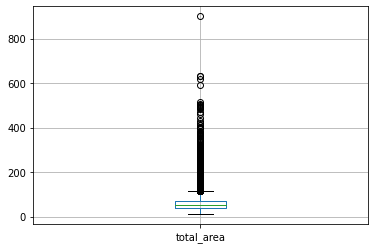

In [40]:
data.boxplot('total_area')

Исключу значения свыше границы верхнего "уса"

In [41]:
for i in ['total_area']:
    q75,q25 = np.percentile(data.loc[:,i],[75,25])
    intr_qr = q75-q25

    maximum = q75+(1.5*intr_qr)
    minimum = q25-(1.5*intr_qr)

    data.loc[data[i] < minimum,i] = np.nan
    data.loc[data[i] > maximum,i] = np.nan

In [42]:
#q75,q25 = np.percentile(data.loc[:,'total_area'],[75,25])
#intr_qr = q75-q25

#maximum = q75+(1.5*intr_qr)
#minimum = q25-(1.5*intr_qr)

#data.loc[data['total_area'] < min,'total_area'] = np.nan
#data.loc[data['total_area'] > max, 'total_area'] = np.nan

In [43]:
data['total_area'].count()

22326

In [44]:
100-(22326*100)/23565

5.257797581158499

Text(0, 0.5, 'Количество объектов')

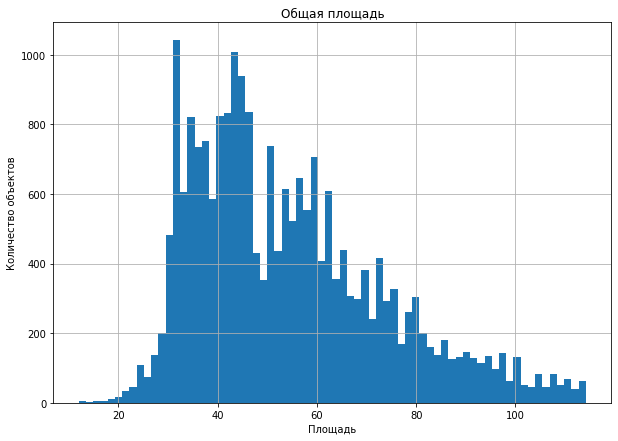

In [45]:
data['total_area'].hist(bins=70, figsize=(10,7))
plt.title('Общая площадь')

plt.xlabel('Площадь')

plt.ylabel('Количество объектов')

In [46]:
data['total_area'].describe()

count    22326.000000
mean        54.319704
std         19.331030
min         12.000000
25%         39.400000
50%         50.000000
75%         65.500000
max        114.200000
Name: total_area, dtype: float64

График распределения выглядит нормальным. Средняя общая площадь квартир составляет 58.8 кв.м. 
Минимальная площадь 12 - в Санкт-Петербурге действительно есть такие объекты недвижимости: комнаты в коммунальных квартирах, например.
Единичные выбросы "за 100 метров" могут быть большими квартирами в старом фонде, особняками или частными домами/коттеджами.

**Жилая площадь**

count    21700.000000
mean        34.454822
std         22.045359
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

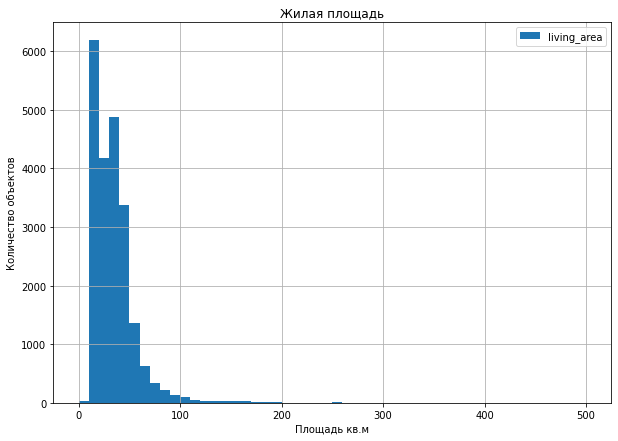

In [47]:
data.plot(y = 'living_area', kind = 'hist', bins = 50, grid=True, figsize = (10,7), range = (0,500))
plt.title('Жилая площадь')
plt.xlabel('Площадь кв.м')
plt.ylabel('Количество объектов')


data['living_area'].describe()

Минимальная жилая площаль 2 кв.м., на первый взгляд выглядит странно, но для коммуналок Петербурга это нормальное явление, график показывает, что такой недвижимости не такое большое количество. 
Среднее говорит о том, что бОльшая часть помещений имеет площадь 33,5 кв.м.
Максимальная площадь 409 кв.м, что вполне достижимо для загородного дома или коттеджа.
Большая часть объектов выборки имеет площадь от 18 кв.м до 41 кв.м.

**Площадь кухни**

count    21343.000000
mean        10.560994
std          5.900630
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

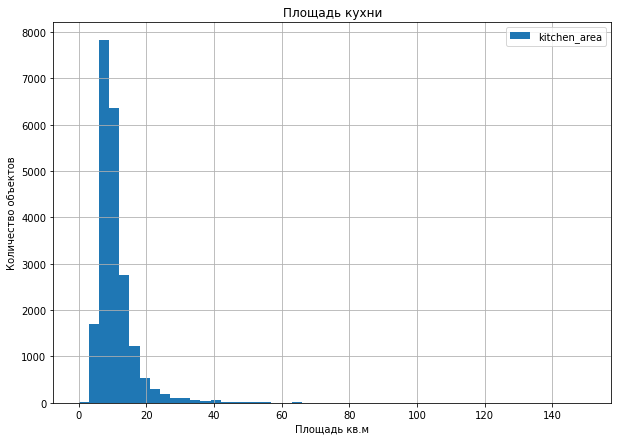

In [48]:
data.plot(y = 'kitchen_area', kind = 'hist', bins = 50, grid=True, figsize = (10,7), range = (0,150))
plt.title('Площадь кухни')
plt.xlabel('Площадь кв.м')
plt.ylabel('Количество объектов')


data['kitchen_area'].describe()

Средняя площадь кухни в объектах 10 кв.м, что выглядит реалистичным.
Самая маленькая кухня размером 2 кв.м может размещаться в хрущевке или переделанной команты в коммуналке (в спб это популярный вид недвижимости).
Кухня размером 112 квадратных метров может быть расположена в коттедже или квартире на крестовском. Судя по графику, таких объектовочень мало

**Цена объекта**

In [49]:
data['last_price'].describe()

count    2.356500e+04
mean     6.540058e+06
std      1.091093e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.646000e+06
75%      6.790000e+06
max      7.630000e+08
Name: last_price, dtype: float64

Среднее и медиана отличаются

<AxesSubplot:>

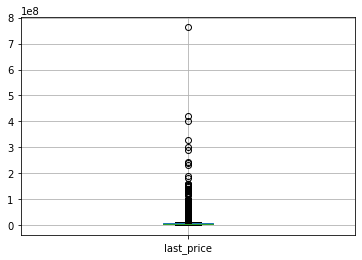

In [50]:
data.boxplot('last_price')

In [51]:
for i in ['last_price']:
    q75,q25 = np.percentile(data.loc[:,i],[75,25])
    intr_qr = q75-q25

    maximum = q75+(1.5*intr_qr)
    minimum = q25-(1.5*intr_qr)

    data.loc[data[i] < minimum,i] = np.nan
    data.loc[data[i] > maximum,i] = np.nan

In [52]:
data['last_price'].count()

21519

In [53]:
100-(21519*100)/23565

8.682367918523227

count    2.151900e+04
mean     4.837115e+06
std      2.215774e+06
min      1.219000e+04
25%      3.300000e+06
50%      4.400000e+06
75%      6.000000e+06
max      1.186686e+07
Name: last_price, dtype: float64

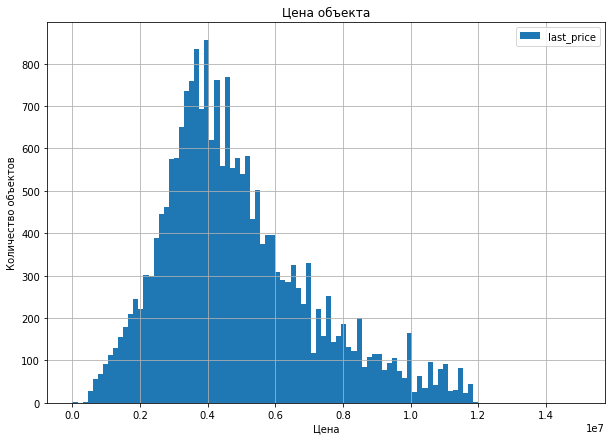

In [54]:
data.plot(y = 'last_price', kind = 'hist', bins = 100, grid=True, range = (0,15000000), figsize = (10,7))
plt.title('Цена объекта')
plt.xlabel('Цена')
plt.ylabel('Количество объектов')
data['last_price'].describe()

После удаления усов среднее и медиана отличаются незначительно

Большая часть квартир стоит от 3,3 до 5,8 млн.
Минимальная цена 1,1 - так может стоить квартира в Ленинградской области, либо "студия" в коммуналке.


**количество комнат,высота потолков**

In [55]:
data['rooms'].describe()

count    23565.000000
mean         2.070656
std          1.078591
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

<AxesSubplot:>

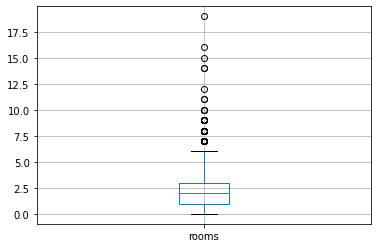

In [56]:
data.boxplot('rooms')

Значения свыше 6 выбросы

In [57]:
for i in ['rooms']:
    q75,q25 = np.percentile(data.loc[:,i],[75,25])
    intr_qr = q75-q25

    maximum = q75+(1.5*intr_qr)
    minimum = q25-(1.5*intr_qr)

    data.loc[data[i] < minimum,i] = np.nan
    data.loc[data[i] > maximum,i] = np.nan

In [58]:
data['rooms'].count()

23475

In [59]:
100-(23475*100)/23565

0.38192234245703105

count    23475.000000
mean         2.047796
std          1.006547
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          6.000000
Name: rooms, dtype: float64

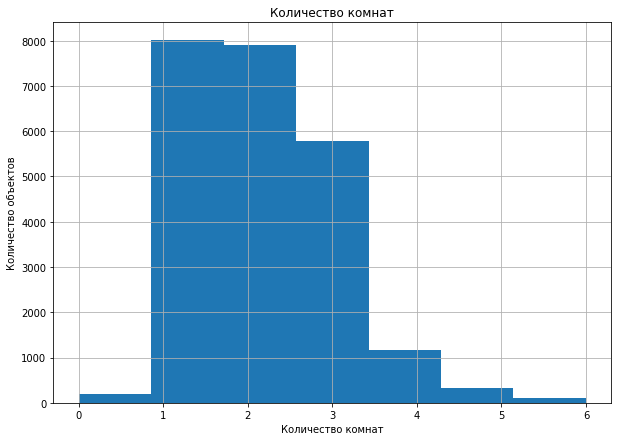

In [60]:
data['rooms'].hist(bins = data['rooms'].nunique(),figsize = (10,7))
plt.title('Количество комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Количество объектов')
data['rooms'].describe()

Количество комнат распредлеилось от 0 (полагаю, что это студии) до 19 (в Санкт-Петербурге есть коммуналки с таким количеством комнат, но это скорее редкость).Обычные квартиры 1-2-3 комантные.

<span style="color:blue;">Количество комнат распределено от 0 до 6. Большее число объектов это 1-2-3 комнатные.</span>

In [61]:
data['ceiling_height'].describe()

count    23565.000000
mean         2.720564
std          0.334172
min          1.000000
25%          2.600000
50%          2.700000
75%          2.700000
max         24.000000
Name: ceiling_height, dtype: float64

<AxesSubplot:>

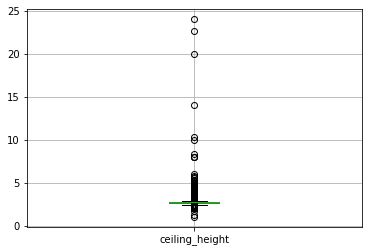

In [62]:
data.boxplot('ceiling_height')

Потолки свыше 2,8 исключим


<span style="color:blue;"> выбросы отброшены на этапе заполнения пропусков</span>

In [63]:
#for i in ['ceiling_height']:
    #q75,q25 = np.percentile(data.loc[:,i],[75,25])
    #intr_qr = q75-q25

    #max = q75+(1.5*intr_qr)
    #min = q25-(1.5*intr_qr)

    #data.loc[data[i] < min,i] = np.nan
    #data.loc[data[i] > max,i] = np.nan

count    23565.000000
mean         2.720564
std          0.334172
min          1.000000
25%          2.600000
50%          2.700000
75%          2.700000
max         24.000000
Name: ceiling_height, dtype: float64

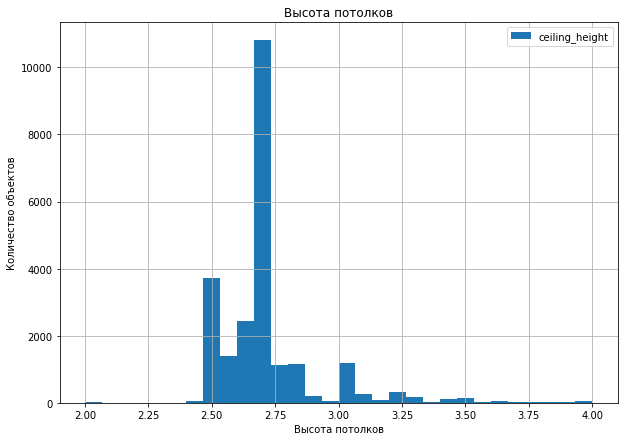

In [64]:
data.plot(y = 'ceiling_height', kind = 'hist', bins = 30, range = (2,4), grid=True, figsize = (10,7))
plt.title('Высота потолков')
plt.xlabel('Высота потолков')
plt.ylabel('Количество объектов')
data['ceiling_height'].describe()

Средняя высота потолков около 2,7. Большая часть данных распределены возле этого значения.
Есть потолок высотой 24 метра маловероятно, что такое возможно.


<span style="color:blue;">после удаления выбросов высота потолков от 2,4 до 2,7 м</span>

**Этаж квартиры,тип этажа квартиры («первый», «последний», «другой»),общее количество этажей в доме**

count    23565.000000
mean         5.878124
std          4.871485
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

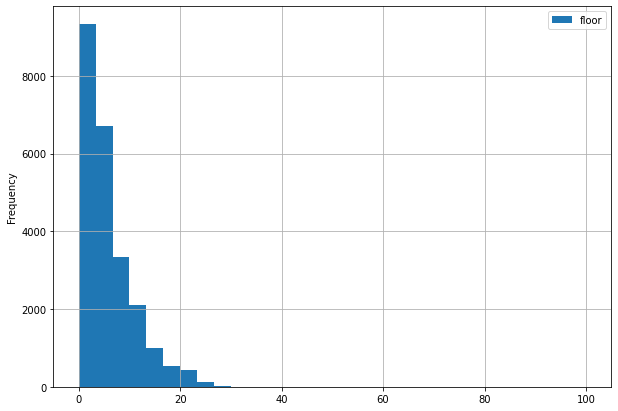

In [65]:
data.plot(y = 'floor', kind = 'hist', bins = 30, range = (0,100), grid=True, figsize = (10,7))
data['floor'].describe()

Среднее количество этажей 5,9. Самый высокий этаж 33. Большинство объектов располагается со 2 по 8 этажи.

**Столбец floors_total**

Text(0, 0.5, 'Количество объектов')

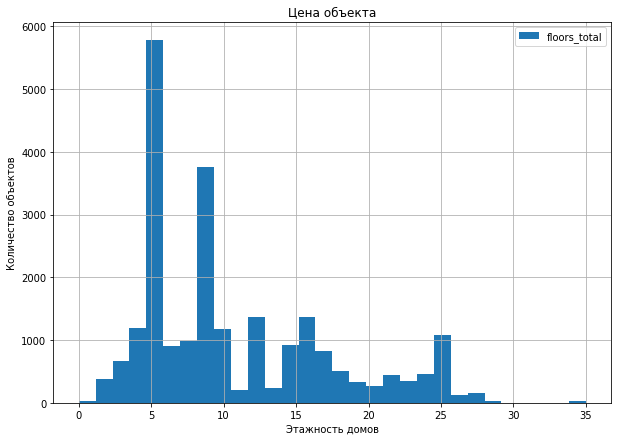

In [66]:
data.plot(y = 'floors_total', kind = 'hist', bins = 30, range = (0,35), grid=True, figsize = (10,7))
plt.title('Цена объекта')
plt.xlabel('Этажность домов')
plt.ylabel('Количество объектов')

Чаще всего объекты продаются в 5 этажных домах, 8 этажных. 


**Столбец floor_type**

In [67]:
data.groupby('floor_type')['floor'].count()

floor_type
другой       17326
первый        2909
последний     3330
Name: floor, dtype: int64

<AxesSubplot:ylabel='floor_type'>

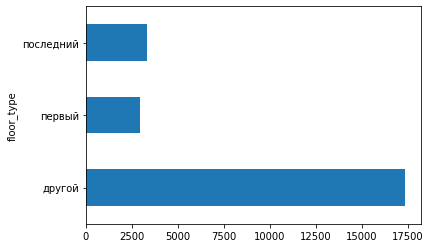

In [68]:
data.groupby('floor_type')['floor'].count().plot(kind = 'barh')

**Расстояние до центра города в метрах,расстояние до ближайшего аэропорта;расстояние до ближайшего парка**

count    18064.000000
mean     14192.656056
std       8613.348153
min        181.000000
25%       9238.000000
50%      13096.500000
75%      16285.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

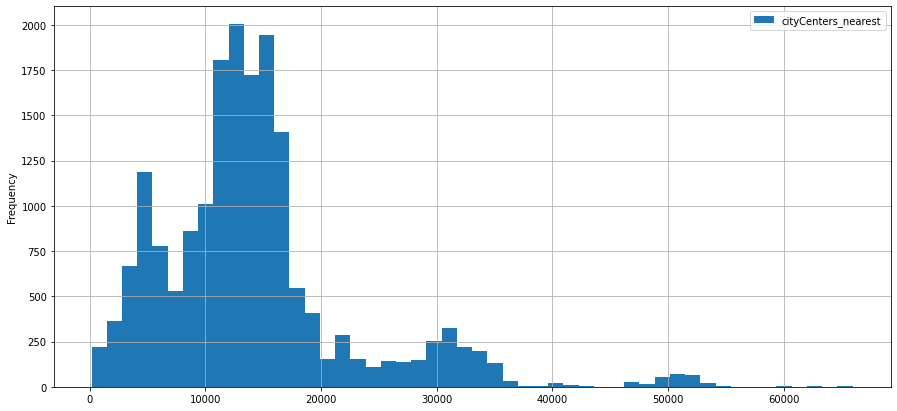

In [69]:
data.plot(y = 'cityCenters_nearest', kind = 'hist', bins = 50, grid=True, figsize = (15,7))
data['cityCenters_nearest'].describe()

В центре продается меньшее число квартир.
Большая часть квартир продается на расстоянии от 12 км до 16 (как раз спальные районы)

count    18041.000000
mean        28.803448
std         12.635231
min          0.000000
25%         19.000000
50%         27.000000
75%         37.000000
max         85.000000
Name: airports_nearest, dtype: float64

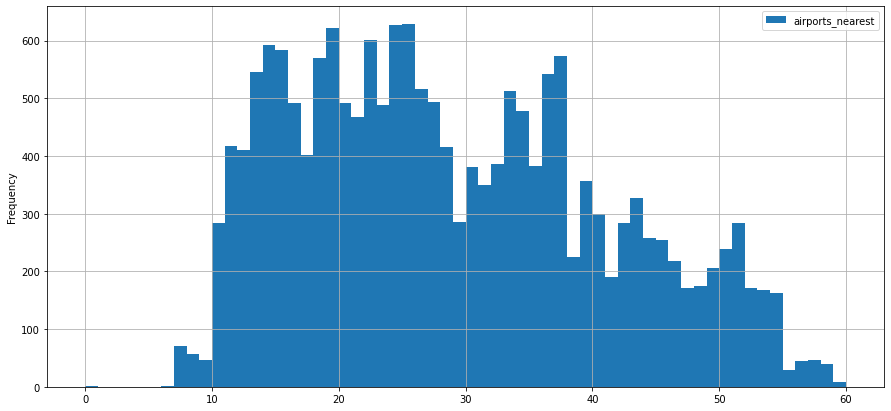

In [70]:
data['airports_nearest'] = (data['airports_nearest']/1000).round()
data.plot(y = 'airports_nearest', kind = 'hist', bins = 60, range = (0,60), grid=True, figsize = (15,7))
data['airports_nearest'].describe()

Самый удаленный объект находится в 85 км от аэропорта. Самый близкорасположенный 0 км (это не значит, что он прямо в аэропорту, например рядом с аэропортом есть поселки и квартал "пулковские высоты" расстояние до него менее 1 км).  В среднем объекты находятся на удалении около 28,5 км

count    8030.000000
mean      490.580448
std       341.572956
min         1.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

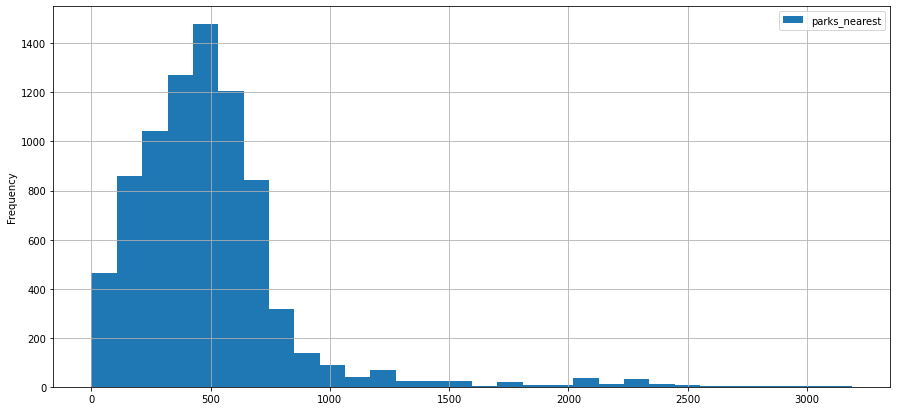

In [71]:
#data['parks_nearest'] = (data['parks_nearest']/1000).round()
data.plot(y = 'parks_nearest', kind = 'hist', bins = 30, grid=True, figsize = (15,7))
data['parks_nearest'].describe()

Боьшинство объектов находится рядом с парками (до 900 метров). Самая далекая прогулка до парка составит 3 км, но таких объектов мало.

**День и месяц публикации объявления**

Text(0, 0.5, 'Количество объектов')

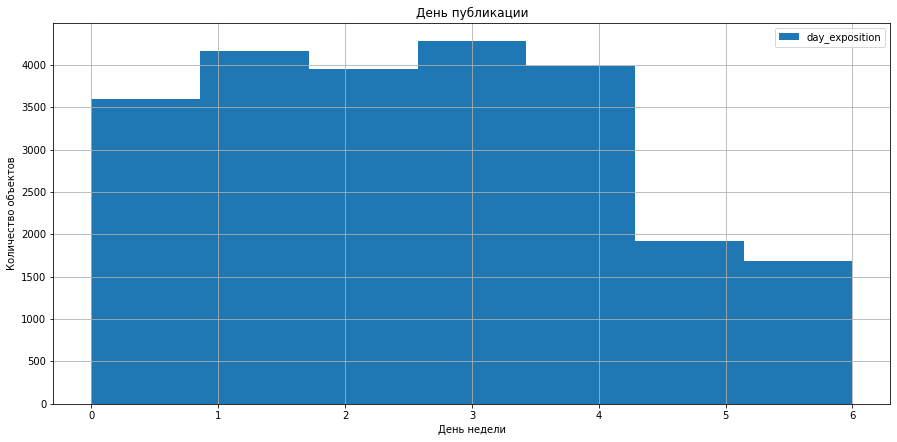

In [72]:
data.plot(y = 'day_exposition', kind = 'hist', bins = 7, grid=True, figsize = (15,7))
plt.title('День публикации')
plt.xlabel('День недели')
plt.ylabel('Количество объектов')


В будние дни число публикаций выше, чем по выходным. Полагаю, что это связано с тем, что к выходным активность пользователей ниже.

<AxesSubplot:ylabel='Frequency'>

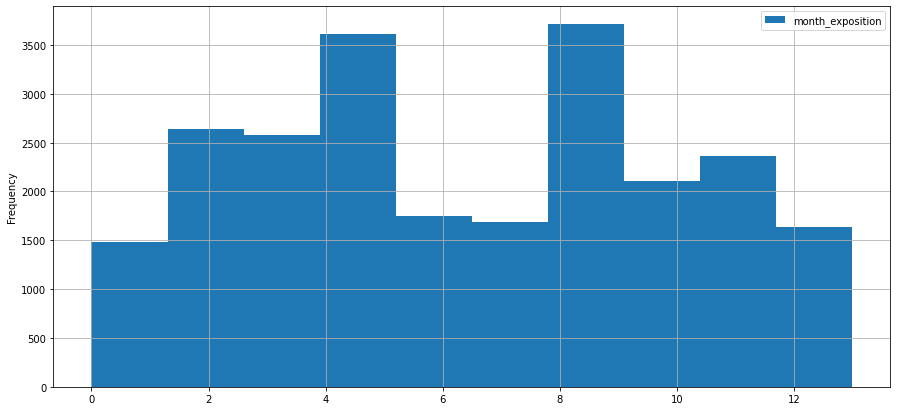

In [73]:
data.plot(y = 'month_exposition', kind = 'hist', bins = 10, range = (0,13), grid=True, figsize = (15,7))

Чаще всего объявления публикуются в конце августа-сентябре. Количество публикаций снижается к лету. Думаю, что здесь роль играет сезонность.

**Изучите, как быстро продавались квартиры**

count    20394.000000
mean       180.741395
std        219.732782
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

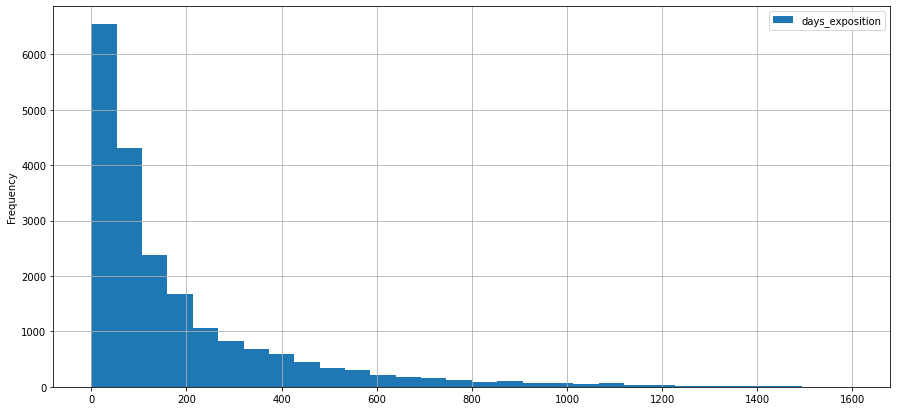

In [74]:
data.plot(y = 'days_exposition', kind = 'hist', bins = 30, range = (0,1600), grid=True, figsize = (15,7))
data['days_exposition'].describe()

Самая быстрая продажа совершилась за 1 день. Обычно продажа занимает от 45 до 231 дня. Самые быстрые продажи до 45 дней. Самые долгие свыше 231 дня. Среднее время продаже 180 дней (полгода).

<AxesSubplot:ylabel='Frequency'>

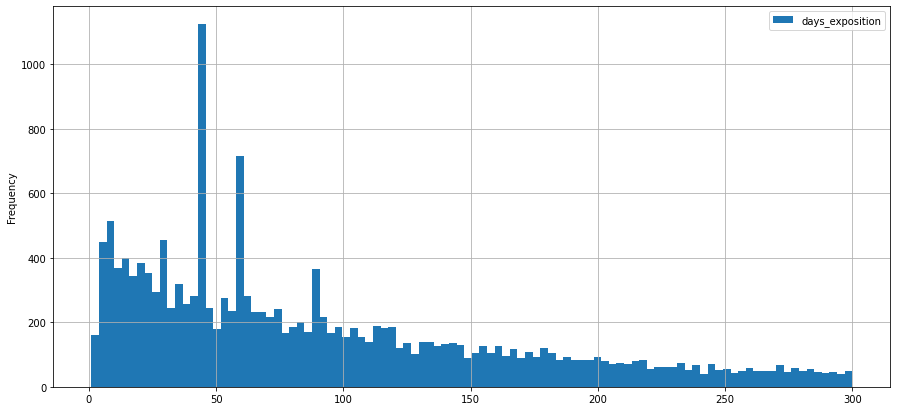

In [75]:
data.plot(y = 'days_exposition', kind = 'hist', bins = 100, grid = True, range = (1,300), figsize = (15,7))

На графике с бОльшимк количеством корзин видны  <span style="color:blue;">пики. Думаю, что они отображают моменты закрытия объявления: </span>.обычно на площадках по размещению объявлений есть определенный срок "жизни" объявления. Например, на авито объявление размещается 30 дней и на 31 автоматически закрывается.

**Какие факторы больше всего влияют на общую (полную) стоимость объекта?**

Изучите, зависит ли цена от:
* 		общей площади;
* 		жилой площади;
* 		площади кухни;
* 		количества комнат;
* 		этажа, на котором расположена квартира (первый, последний, другой);
* 		даты размещения (день недели, месяц, год).

Постройте графики, которые покажут зависимость цены от указанных выше параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы.

*общей площади*

In [76]:
#table_total_area = data.pivot_table(index = 'total_area', values = 'last_price', aggfunc = ['mean', 'median'])
#table_total_area.columns = ['mean','median']
#table_total_area.plot(y = 'median', style = 'o')
#table_total_area.sort_values('median', ascending = False)


In [77]:
#data['total_area'].corr(data['last_price'])

Стоимость объектов растет в зависимоти от общей площади. Зависимость между общей площадью и полной стоимостью заметная.


<AxesSubplot:xlabel='total_area', ylabel='last_price'>

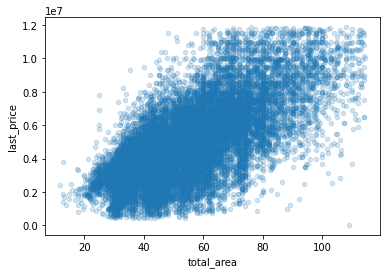

In [78]:
data.plot(x = 'total_area', y = 'last_price', kind = 'scatter', alpha = 0.2)



In [79]:
data['total_area'].corr(data['last_price'])

0.6940523107096932

*жилой площади*

In [80]:
#table_living_area = data.pivot_table(index = 'living_area', values = 'last_price', aggfunc = ['mean', 'median'])
#table_living_area.columns = ['mean','median']
#table_living_area.plot(y = 'median', style = 'o')
#table_living_area.sort_values('median', ascending = False)

In [81]:
#data['living_area'].corr(data['last_price'])

Чем выше жилая площадь , тем выше стоимость объекта. Зависимость между жилой площадью и полной стоимостью объекта заметная. Коэф корреляции 0,57

<AxesSubplot:xlabel='living_area', ylabel='last_price'>

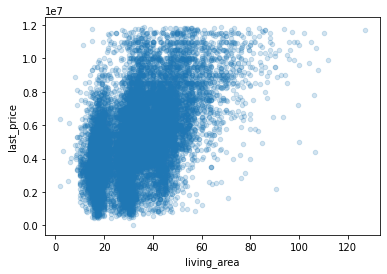

In [82]:
data.plot(x = 'living_area', y = 'last_price', kind = 'scatter', alpha = 0.2)



In [83]:
data['living_area'].corr(data['last_price'])

0.5806850807891172

*площади кухни*

In [84]:
#table_kitchen_area = data.pivot_table(index = 'kitchen_area', values = 'last_price', aggfunc = ['mean', 'median'])
#table_kitchen_area.columns = ['mean','median']
#table_kitchen_area.plot(y = 'median', style = 'o')
#table_kitchen_area.sort_values('median', ascending = False)

In [85]:
#data['kitchen_area'].corr(data['last_price'])

Зависимоть площади кухни и цены не такая сильная. Например объект с площадью кухни 72 метра стоит дороже объекта с площадью 112 метров. Однако в целом цена зависит и от площади кухни. Зависимость умеренная.

<AxesSubplot:xlabel='kitchen_area', ylabel='last_price'>

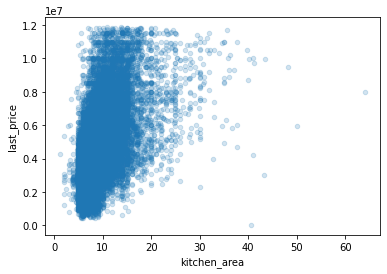

In [86]:
data.plot(x = 'kitchen_area', y = 'last_price', kind = 'scatter', alpha = 0.2)


In [87]:
data['kitchen_area'].corr(data['last_price'])

0.4820980345241328

*количества комнат*

,mean,count,median
rooms,,,
5.0,8.252059e+06,118,8945000.0
4.0,6.908274e+06,752,6965000.0
3.0,5.989371e+06,4918,5700000.0
2.0,5.004344e+06,7558,4650000.0
1.0,3.757081e+06,7964,3600000.0
0.0,2.924644e+06,192,2700000.0


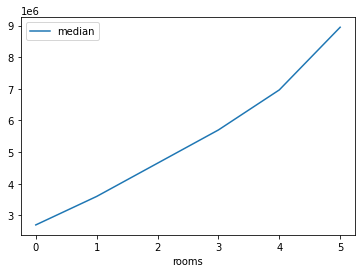

In [88]:
rooms_table = data.pivot_table(index = 'rooms', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
rooms_table.columns = ['mean', 'count', 'median']
rooms_table.query('count > 50').plot(y = 'median')
rooms_table.query('count > 50').sort_values('median', ascending = False)

In [89]:
data['rooms'].corr(data['last_price'])

0.4516530750735998

Самая низкая стоимость у квартир с 3 команатами. Самая высокая с комнатами 0-1-2 (0 комант могут быть студии или квартиры сл свободной планировкой). <span style="color:blue;">Зависимость между количество комнат и полосй стоимостью умеренная</span>

*этажа, на котором расположена квартира*

,mean,count,median
floor_type,,,
другой,5.031206e+06,15733,4590000.0
последний,4.481128e+06,2988,4000000.0


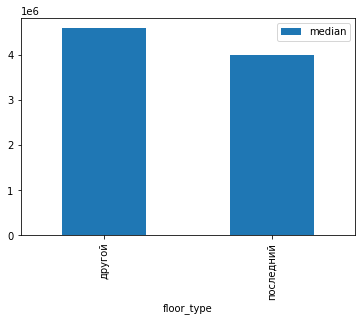

In [90]:
table_floor_category = data.query('floor_type != "первый"').pivot_table(index = 'floor_type', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
table_floor_category.columns = ['mean', 'count', 'median']
table_floor_category.plot(y = 'median',kind = 'bar')
table_floor_category

Квартиры на других этажах дороже чем на последнем.

,mean,count,median
floor_type,,,
первый,4.125910e+06,2798,3800000.0
последний,4.481128e+06,2988,4000000.0


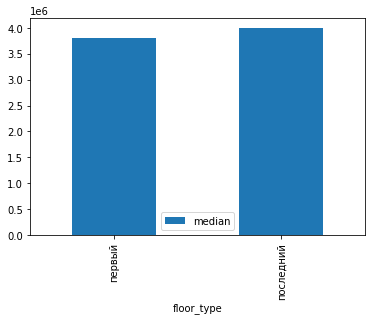

In [91]:
table_floor_category = data.query('floor_type != "другой"').pivot_table(index = 'floor_type', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
table_floor_category.columns = ['mean', 'count', 'median']
table_floor_category.plot(y = 'median',kind = 'bar')
table_floor_category



Квартиры на 1 этаже дешевле, чем квартиры на последнем.

**даты размещения**

*день недели*

,median
day_exposition,
1,4499000.0
2,4490000.0
0,4400000.0
3,4400000.0
5,4400000.0
4,4350000.0
6,4350000.0


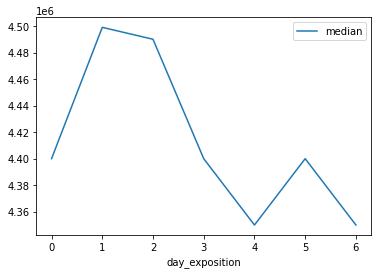

In [92]:
table_day_exposition = data.pivot_table(index = 'day_exposition', values = 'last_price', aggfunc = ['median'])
table_day_exposition.columns = ['median']
table_day_exposition.plot(y = 'median')

table_day_exposition.sort_values('median', ascending = False)



В середине недели стоимость выше. К выходным снижается. Думаю, что это связано с тем, что в середине недели вероятность продать объект выше (выше активность покупателей) к выходным она снижается, так как снижается активность покупателей.


<span style="color:blue;">Самая высокая стоимость у объявлений размещенных во вторник и субботу</span>


*месяц*

,median
month_exposition,
4,4552500.0
12,4480000.0
11,4455000.0
9,4450000.0
1,4400000.0
2,4400000.0
3,4400000.0
10,4400000.0
8,4380000.0


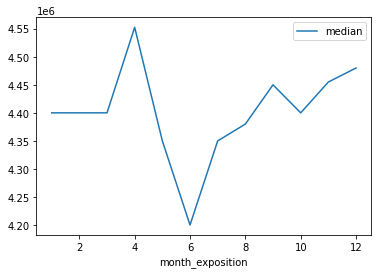

In [93]:
table_month_exposition = data.pivot_table(index = 'month_exposition', values = 'last_price', aggfunc = ['median'])
table_month_exposition.columns = ['median']
table_month_exposition.plot(y = 'median')

table_month_exposition.sort_values('median', ascending = False)



Цена зависит от сезонности: самые высокие цены в сентябре (люди возвращаются с дач и отпусков - сентябрь сезон роста продаж, высокий спрос порождает повышение цен). Самые низкие цены в мае-июне. Думаю, что это связано с сезонностью: обычно продажи в летние месяцы сокращаются, а с ними и цена.

<span style="color:blue;">С апреля по июнь цены снижаются. В июне полная стоимость объектов самая низкая. Далее уже идет рост цены. умаю, что это связано с сезонностью: обычно продажи в летние месяцы сокращаются, а с ними и цена. </span>

*год*

,median
year_exposition,
2014,5500000.0
2015,4885000.0
2019,4800000.0
2018,4390000.0
2016,4300000.0
2017,4299000.0


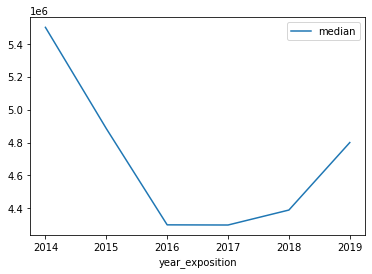

In [94]:
table_year_exposition = data.pivot_table(index = 'year_exposition', values = 'last_price', aggfunc = ['median'])
table_year_exposition.columns = ['median']
table_year_exposition.plot(y = 'median')

table_year_exposition.sort_values('median', ascending = False)


Самые высокие цены в 2014 году. Думаю, что это связано с экономической ситуацией в стране (когда рубль упал). Далее ситуация стабилизируется, но к 2019 году цены возвращаются на уровень 2014 года. 


<span style="color:blue;">Самые высокие цены в начале 2014 года, думаю, что это связано с политической обстановкой (снакции, Крым, падение рубля), далее цена снижается. Незначительный рост цен начинается с 2018 года.</span>

**Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра.**

<AxesSubplot:xlabel='locality_name'>

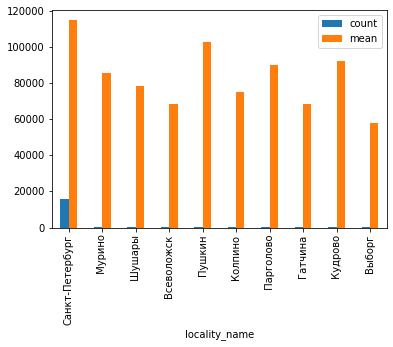

In [95]:
top_location = data.pivot_table(index = 'locality_name', values = 'price_one_square_meter', aggfunc=['count', 'mean'])
top_location.columns = ['count', 'mean']
top_location = top_location.sort_values('count', ascending = False).head(10)
top_location.plot(kind = 'bar')


In [96]:
top_location[top_location['mean']==top_location['mean'].max()] #самая высокая стоимость

,count,mean
locality_name,,
Санкт-Петербург,15651,114868.433902


In [97]:
top_location[top_location['mean']==top_location['mean'].min()] #самая низкая стоимость


,count,mean
locality_name,,
Выборг,237,58141.489451


Населенный пункт с самой высокой ценой квадратного метра -- Санкт-Петербург.
Населенный пункт с самой низкой ценой квадратного метра -- Выборг.
Санкт-Петербург  -- крупный город с развитой инфраструктурой, в нем есть аэропорт и 5 вокзалов. Город большой и быстро развивающийся. Строительство объектов недвижимости развито.
Выборг -- это небольшой город в Ленинградской области почти на границе с Финляндией (я считаю, что это приемущество :)) с небольшим населением и старым фондом. 

**Теперь выделите квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города.**

In [98]:
center_long = data.query('locality_name == "Санкт-Петербург" and cityCenters_nearest_km <= 20').pivot_table(index = 'cityCenters_nearest_km', values = 'price_one_square_meter', aggfunc = 'mean')
center_long


,price_one_square_meter
cityCenters_nearest_km,
0,245833.111111
1,177004.963542
2,157848.564516
3,121507.367816
4,133282.422965
5,140453.507104
6,151011.750809
7,156176.445238
8,125649.319865


<AxesSubplot:xlabel='cityCenters_nearest_km'>

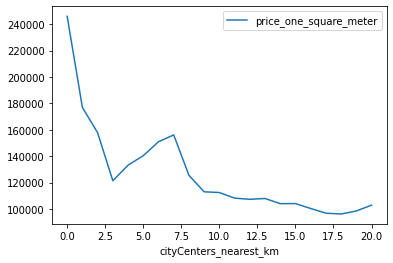

In [99]:
center_long.plot()

Самая высокая цена в центре Санкт-Петербурга. Чем дальше от центра, тем ниже цена.
По графику видно, что на отметке 7 км есть рост цены, думаю, что это связано с тем, что в 7 км от географического центра Санкт-Петербурга нахоится престижный район "Крестовский остров" с элитной недвижимостью.
Далее цена падает с каждым километром. 

### Общий вывод

Я открыла и изучила файл.
Заполнила пропускм там, где это возможно. 
Изменила типы данных и привела их к более понятному виду (например, расстояния перевела в км).
Добавила столбцы, с необходимыми расчетами.

Исходя из анализа можно сделать вывод, что:
* Стоимость объекта зависит от удаленности от центра Санкт-Петербурга. Чем объект дальше от центра, тем ниже  стоимость кв.м. Объекты на расстоянии 7-7,5 км от центра стоят дороже, чеи объеты на расстоянии 2,5-5 км.
* В выборке 10 населенных пунктов, где размщено больше всего объявлений: самая высокая стоимость кв м в Санкт-Петербурге, самая низкая в Выборге. 
* Самая высокая стоимость кв.м была в 2014 и 2019 годах. Предположу, что это связано с экономической обстановкой.
* Цена кв.м зависит от сезона размещения объявлений (думаю, что от сезона в целом): к осени стоимость растет, весной и летом падает.
* В середине недели размещались объекты по бОльшей стоимость кв.м, к выходным с меньшей.
* Этажность влияет на стоимость кв. м: объекты на первом и последнем этаже стоят дешевле других этажей.
* Стоимость кв. м зависит от кол-ва комнат: самая низкая у объектов с 3 комнатами.
* Стоимость зависит от жилой площади: чем выше площадь, тем выше стоимо